# Music Emotion Recognition
This notebook provides the code for implementing a BERT classiier 

## Importing libraries

In [1]:
# !pip install music21 miditoolkit miditok

In [1]:
# %pip install --user torch==1.7.0 torchvision==0.8.1 -f https://download.pytorch.org/whl/cu102/torch_stable.html

In [2]:
# !pip install transformers

In [2]:
import numpy as np 
import pandas as pd 
from io import open
import tensorflow as tf
import glob
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import time
from miditok import get_midi_programs, REMI, MIDILike
from miditoolkit import MidiFile
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, BertConfig, BertModel

C:\ProgramData\Anaconda3\envs\newpydisser\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
torch.__version__

'1.7.0'

In [4]:
device = 'cuda'

In [5]:
torch.cuda.empty_cache()

In [6]:
torch.cuda.is_available()

True

In [7]:
# Seed
# seed = 22
# torch.manual_seed(seed)
# torch.cuda.manual_seed(seed)
# torch.cuda.manual_seed_all(seed)
# np.random.seed(seed)
# torch.backends.cudnn.benchmark = False
# torch.backends.cudnn.deterministic = True

## Loading the Dataset

In [8]:
# how a midi file looks like
midi = MidiFile('archive/EMOPIA_1.0 (1)/EMOPIA_1.0/midis/Q1__8v0MFBZoco_0.mid')
midi

ticks per beat: 384
max tick: 46051
tempo changes: 1
time sig: 1
key sig: 0
markers: 0
lyrics: False
instruments: 1

In [9]:
# for now, we will only be using for piano right since it determines the melody
midi.instruments

[Instrument(program=0, is_drum=False, name="")]

In [10]:
# file path to the MIDI files
files_paths = list(glob.glob('archive/EMOPIA_1.0 (1)/EMOPIA_1.0/midis/*.mid'))
# reading labels
labels_df = pd.read_csv('archive/EMOPIA_1.0 (1)/EMOPIA_1.0/label.csv')
labels_df = list(labels_df['4Q'])

In [11]:
import muspy

def return_range(music):
    h = 0
    l = 127
    for track in music.tracks:
        for note in track.notes:
            if note.pitch > h:
                h = note.pitch
            if note.pitch < l:
                l = note.pitch
    return [h, l]

tempos = []
pitches = []

for file in files_paths:
    music = muspy.read_midi(file)
    tempos.append(music.tempos[0].qpm)
    pitches.extend(return_range(music))

In [12]:
print("The unique tempos found in the dataset are: ", set(tempos))
print('minimum pitch found', min(pitches))
print('maximum pitch found', max(pitches))

The unique tempos found in the dataset are:  {120.0}
minimum pitch found 22
maximum pitch found 105


In [13]:
pitch_range = range(22, 105)
additional_tokens = {'Chord': True, 'Rest': True, 'Tempo': True, 'Program': False,
                     'rest_range': (2, 4),  # (half, 8 beats)
                     'nb_tempos': 32,  # nb of tempo bins
                     'tempo_range': (100, 140),
                     'TimeSignature':None}  # (min, max)

In [14]:
# create a list of notes

def load_files(files_paths, encoder = REMI(additional_tokens)):
    assert len(files_paths) > 0
    notes = []


    for file in files_paths:
        # file_name = os.path.basename(file)

        # read the MIDI file
        midi = MidiFile(file)

        # Converts MIDI to tokens
        tokens = encoder.midi_to_tokens(midi)
        
        # The EMOPIA dataset has midi files with only one instrument, i.e. the piano 
        # hence we just add those tokens
        # print(tokens)
        notes.append(tokens[0])

    return notes, encoder

In [15]:
notes, midi_enc = load_files(files_paths, MIDILike(pitch_range, additional_tokens = additional_tokens))

In [16]:
print("There are",len(midi_enc.vocab),"unique tokens in the files")

There are 317 unique tokens in the files


In [17]:
# Create a dataset corpus from the notes and labels
class Corpus(Dataset):
    def __init__(self, notes, labels, encoder, seq_length):
        self.encoder = encoder
        self.seq_len = seq_length

        
        self.xtrain, self.ytrain= self.tokenize(notes, labels)
        # self.xtest, self.ytest, _, _ = self.tokenize(ntest, ltest)
        # self.xvalid = self.tokenize(ntest, ltest)
    
    def __len__(self):
        return len(self.encoder.vocab)

    def len_dataset(self):
        return len(self.xtrain)
    
    def __getitem__(self, index, ):
        return self.xtrain[index], self.ytrain[index]
    
    def tokenize(self, notes, labels):
        assert len(notes) > 0
        assert len(labels) > 0

        # create a set of notes
        # they should all be padded to have sequence of len seq_len
        songss = []
        target = []

        for song, label in zip(notes, labels):
            song = torch.tensor(song).type(torch.int64)
            songs = list(song.split(self.seq_len))

            for i in range(len(songs)):
                # removing sequences that have < seq len/4 tokens
                if len(songs[i]) < self.seq_len/4:
                    del songs[i]
                    continue
                target.append(label-1)
            songss.extend(songs)
        
        # padding songs to be of same length
        data = pad_sequence(songss)
        data = data.T
        target = torch.LongTensor(target)

        # corpus = []

        # corpus = torch.stack(corpus)

        # creates the range of each type of token
        # for eg. family is [0, 2, 3]
        
        
        # token_ranges = [corpus[:,:,i].squeeze().unique() for i in range(7)]
        
        # # creates a reverse dictionary for each token
        # # for eg. family is {0: 0, 2: 1, 3: 2}
        # token_dicts = [dict(zip(tokens.tolist(), range(len(tokens)))) for tokens in token_ranges]

        # data = corpus.clone().detach()
        # for i in range(len(corpus)):
        #     for k in range(7):
        #         data[i,:,k] = torch.tensor([token_dicts[k][l.item()] for l in corpus[i,:,k]])

        # data = new_corpus[:,:self.seq_len - 1, :]
        # target = new_corpus[:,1:self.seq_len, :]
            

        # converting all the tokens in each type to new values:
        return data, target

In [18]:
ntrain, ntest, ltrain, ltest = train_test_split(notes, labels_df, test_size=0.3, random_state=42, shuffle=True, stratify=labels_df)
train_corpus = Corpus(ntrain, ltrain, midi_enc, 50)
val_corpus = Corpus(ntest, ltest, midi_enc, 50)

In [19]:
xtest = val_corpus.xtrain
xtrain = train_corpus.xtrain
# ytest = val_corpus.ytrain
# ytrain = train_corpus.ytrain


# train_emo = corpus.ytrain.to(device)
# val_emo = corpus.yvalid.to(device)

print("train data shape:", train_corpus.xtrain.shape)
print("test data shape:", val_corpus.xtrain.shape)
print("train data shape:", train_corpus.ytrain.shape)
print("test data shape:", val_corpus.ytrain.shape)

train data shape: torch.Size([15104, 50])
test data shape: torch.Size([6560, 50])
train data shape: torch.Size([15104])
test data shape: torch.Size([6560])


In [20]:
batch_size = 32
# creating a dataloader
train_dataloader = DataLoader(
    train_corpus,
    sampler=SequentialSampler(xtrain),
    batch_size=batch_size,
)
val_dataloader = DataLoader(
    val_corpus,
    sampler=SequentialSampler(xtest),
    batch_size=batch_size,
)

In [21]:
print("There are total",len(notes), "songs and a total of", xtrain.shape[0] + xtest.shape[0], "sequences extracted")

There are total 1078 songs and a total of 21664 sequences extracted


In [22]:
print("There are",len(train_corpus), "unique tokens")

There are 317 unique tokens


## Model Building

### Constants

In [23]:
# size of the model
ntokens = len(train_corpus)
emsize = 256

# parameters for the transformers
nhid = 252

# dropout
dropout = 0.4

# learning rates for each
lr = 0.001


## Classifier

In [24]:
# Adapted from 
# https://github.com/wazenmai/MIDI-BERT/blob/main/MidiBERT/remi/main.py

In [25]:
class BERTClassifier(nn.Module):
    def __init__(self, ntokens, nhid=252, max_len = 50, vocab_size = ntokens, num_hidden_layers = 4, num_attention_heads = 6):
        super().__init__()

        config = BertConfig(vocab_size = vocab_size, num_hidden_layers = num_hidden_layers, num_attention_heads = num_attention_heads, max_position_embeddings=max_len, position_embedding_type='relative_key_query', hidden_size=nhid)     
        self.d_model = nhid
        self.nhid = nhid

        self.n_token = ntokens
        self.emb_size = 256
        
        # creates an embedding of the tokens
        self.embedding = nn.Embedding(self.n_token, self.emb_size) 

        # passing through a linear layer, to reduce the features to the dimension of the model 
        self.in_linear = nn.Linear(self.emb_size, self.d_model)
        
        # pass through a BERT model
        self.bert = BertModel(config)

        # output to 4 classes
        self.out_linear = nn.Linear(self.d_model, 4)


    def forward(self, x, attn_mask=None):
        # create embedding
        x = x.to(device)
        if attn_mask != None:
            attn_mask = attn_mask.to(device)
        x = self.embedding(x) * math.sqrt(self.d_model)
        # linear layer
        x = self.in_linear(x)
        
        x = self.bert(inputs_embeds=x, attention_mask=attn_mask, output_hidden_states=True)
        
        x = x.hidden_states[-1]
        x = x.mean(dim=1)
        x = self.out_linear(x)
        # print(x.shape)

        return x

In [26]:
model = BERTClassifier(ntokens, nhid=nhid)
model.to(device)

BERTClassifier(
  (embedding): Embedding(317, 256)
  (in_linear): Linear(in_features=256, out_features=252, bias=True)
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(317, 252, padding_idx=0)
      (position_embeddings): Embedding(50, 252)
      (token_type_embeddings): Embedding(2, 252)
      (LayerNorm): LayerNorm((252,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=252, out_features=252, bias=True)
              (key): Linear(in_features=252, out_features=252, bias=True)
              (value): Linear(in_features=252, out_features=252, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
              (distance_embedding): Embedding(99, 42)
            )
            (output): BertSelfOutput(


In [27]:
def network_paras(model):
    # compute only trainable params
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    return params

In [28]:
print("There are",network_paras(model),"parameters in the model")

There are 7551384 parameters in the model


## Training

In [29]:
import torch
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

In [30]:
len(train_dataloader)

472

In [31]:
pad_token = midi_enc.vocab.event_to_token['PAD_None']
pad_token

0

In [32]:
from time import time
from sklearn.metrics import f1_score, accuracy_score

model.train()
crit = nn.CrossEntropyLoss(reduction='mean')
optim = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.01)

def train():
    epochs = 200
    batches = len(train_dataloader)

    losses, accuracies = [], []
    start = time()
    
    for epoch in range(epochs):

        model.zero_grad()
        
        total_loss, total_acc  = 0, 0

        for bidx, (xtrain, ytrain)  in enumerate(train_dataloader): 
            optim.zero_grad()
            xtrain.to(device)
            ytrain.to(device)

            # loss_mask = torch.ones(xtrain.size(0), (xtrain.size(1)))

            attn_mask =  (xtrain != pad_token).float().to(device)  

            y = model(xtrain, attn_mask)

            learning = np.argmax(y.cpu().detach(), axis=-1)
            learning = learning.type(torch.float)

            acc = accuracy_score(ytrain, learning)
            # print(target.shape, learning.shape)
    
            # calculate losses
            loss = crit(y.cpu(), ytrain.cpu())
            
            total_loss += loss
            total_acc += acc
        
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 3.0)
            optim.step()

        losses.append(total_loss/ batches)
        accuracies.append(total_acc / batches)

        writer.add_scalar("Training Loss", losses[-1], epoch)
        writer.add_scalar("Training Accuracy", accuracies[-1], epoch)
        
        print(f"Epoch {epoch+1}/{epochs} ({int(time() - start)}s):"
              f" Training Loss: {losses[-1]:.3f},"
              f" Training Accuracy: {accuracies[-1]:.3f}")
train()

Epoch 1/200 (17s): Training Loss: 1.152, Training Accuracy: 0.455


KeyboardInterrupt: 

In [1]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

Model's state_dict:


NameError: name 'model' is not defined

In [32]:
torch.save(model.state_dict(), './models/bert_mer_final.pt')

## Evaluate 

In [39]:
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
model.eval()
cms = torch.zeros((4,4))
def eval(cms):
    batches = len(val_dataloader)
        
    total_loss, total_acc  = 0, 0

    with torch.no_grad():
        for bidx, (xtest, ytest)  in enumerate(val_dataloader): 
            xtest.to(device)
            ytest.to(device)

            attn_mask =  (xtest != pad_token).float().to(device)  

            y = model(xtest, attn_mask)

            y_pred = np.argmax(y.cpu().detach(), axis=-1)
            y_pred = y_pred.type(torch.float)

            acc = accuracy_score(ytest, y_pred)

            cm = confusion_matrix(ytest, y_pred, labels=range(4), normalize='true')

            cms += cm

            loss = crit(y.cpu(), ytest.cpu())
            
            total_loss += loss
            total_acc += acc


    total_loss = (total_loss/ batches)
    total_acc = (total_acc / batches)

    
    print(f" Testing Loss: {total_loss:.3f},"
          f" Testing Accuracy: {total_acc:.3f}")

    return cms
cms = eval(cms)

 Testing Loss: 0.989, Testing Accuracy: 0.591


In [37]:
cms

tensor([[62.6556, 32.3889,  1.3749,  5.5807],
        [30.9377, 76.3917,  4.3522,  7.3184],
        [17.2699,  4.4761, 26.4841, 43.7700],
        [14.9345,  2.4288,  9.1659, 83.4708]], dtype=torch.float64)

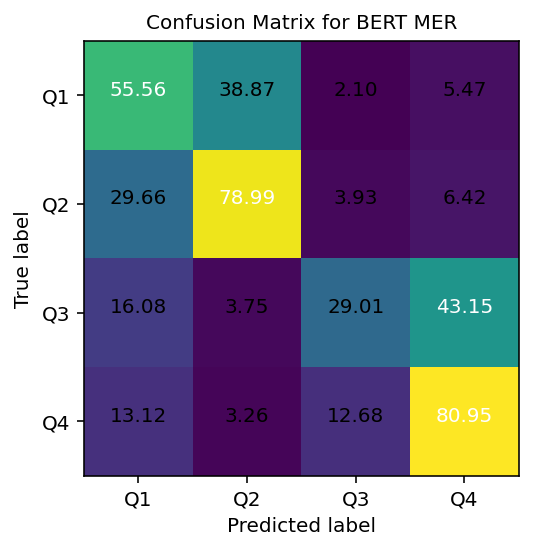

In [59]:
import itertools

plt.figure(figsize=(8, 4))
plt.imshow(cms, interpolation='nearest')
plt.title('Confusion Matrix for BERT MER', fontsize=10)
labels = ['Q'+str(i+1) for i in range(4)]
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, fontsize=10)
plt.yticks(tick_marks, labels, fontsize=10)

# print('Confusion matrix, without normalization')

thresh = cms.max() / 2.
for i, j in itertools.product(range(cms.shape[0]), range(cms.shape[1])):
    plt.text(j, i, format(cms[i, j], '.2f'),
                horizontalalignment="center",
                color="white" if cms[i, j] > thresh else "black",
                fontsize=10)

plt.ylabel('True label', fontsize=10)
plt.xlabel('Predicted label', fontsize=10)
plt.savefig("bert_classification_58.png")

<Figure size 432x288 with 0 Axes>

## Generate

In [71]:
model = BERTClassifier(ntokens)
model.to(device)
model.load_state_dict(torch.load('./models/bert_mer.pt'))
model.eval()

MidiTransGAN(
  (generator): Generator(
    (criterion): CrossEntropyLoss()
    (embedding_family): Embedding(3, 32)
    (embedding_bar): Embedding(35, 128)
    (embedding_pitch): Embedding(85, 512)
    (embedding_velocity): Embedding(32, 128)
    (embedding_duration): Embedding(66, 256)
    (embedding_chord): Embedding(16, 64)
    (embedding_rest): Embedding(7, 64)
    (embedding_tempo): Embedding(3, 32)
    (embedding_emotion): Embedding(4, 512)
    (in_linear): Linear(in_features=1728, out_features=256, bias=True)
    (pos_encoder): PositionalEncoding(
      (dropout): Dropout(p=0.4, inplace=False)
    )
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): _LinearWithBias(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=2048, bias=True)
          (dropout): Dropout(p=0.4, inplace=False)
          (linear

In [72]:
# tensorboard
# https://pytorch.org/tutorials/recipes/recipes/tensorboard_with_pytorch.html?msclkid=ce0b97e5b41911ec9d2e71bb3c7d0f90

In [73]:
# !pip install muspy
import muspy

In [74]:
# TODO: fix the generate sample function to handle batch size = 1
sequences = []
for emo in range(0,4):
    n_generate = 200
    temperature = 1
    log_interval = 4000 # interval between logs

    notes = []
    for token in ntokens[:-1]:
        # print(token)
        notes.append(torch.randint(token, (1, 2), dtype=torch.long).to(device))
    

    emotions = torch.full((1, 2), emo).to(device)
    
    notes.append(emotions)

    # stacked input
    inputs = torch.stack(notes, dim=-1)
    print(len(inputs))
        
    src_mask = generate_square_subsequent_mask(len(inputs)).to(device)

    output = gan.generate_samples(latent_vec=inputs, emotion=emo, num=n_generate, src_mask=None, display=False)

    for i in range(len(output)):
        # output[i,:,0] = torch.tensor([tokens_to_raw[0][l] for l in output[i,:,0]])
        for k in range(0,8):
            output[i,:,k] = torch.tensor([tokens_to_raw[k][l] for l in output[i,:,k]])
    # print(output)
    # if i % log_interval == 0:
    print('| Generated {} notes'.format(n_generate))
    sequences.append([output[:,2:,:-1].squeeze().cpu().tolist()])

1
| Generated 200 notes
1
| Generated 200 notes
1
| Generated 200 notes
1
| Generated 200 notes


In [75]:
import muspy

In [76]:
sequences

[[[[2, 199, 34, 101, 179, 230, 0, 261],
   [2, 205, 72, 113, 165, 221, 243, 261],
   [3, 197, 72, 100, 148, 222, 243, 261],
   [2, 192, 12, 92, 158, 229, 241, 261],
   [2, 189, 81, 95, 170, 227, 0, 261],
   [2, 0, 64, 93, 183, 225, 238, 261],
   [2, 207, 67, 102, 124, 232, 240, 0],
   [2, 208, 69, 114, 148, 223, 240, 244],
   [2, 210, 57, 109, 165, 223, 241, 261],
   [2, 208, 61, 95, 140, 225, 238, 244],
   [2, 191, 33, 108, 177, 221, 0, 244],
   [2, 190, 20, 103, 148, 229, 239, 244],
   [2, 209, 74, 92, 142, 231, 239, 0],
   [2, 208, 68, 111, 150, 231, 241, 0],
   [2, 191, 51, 111, 126, 230, 238, 244],
   [2, 215, 25, 92, 172, 227, 241, 261],
   [2, 1, 57, 96, 135, 229, 238, 261],
   [3, 189, 83, 110, 155, 221, 242, 261],
   [2, 213, 7, 96, 185, 232, 243, 261],
   [3, 195, 18, 98, 174, 221, 243, 261],
   [2, 219, 51, 105, 143, 220, 240, 244],
   [3, 198, 9, 114, 138, 221, 242, 261],
   [2, 0, 71, 115, 125, 231, 241, 261],
   [3, 196, 37, 95, 143, 222, 242, 261],
   [2, 197, 35, 112, 1

In [77]:
date = '15_04_'
pitch_ranges = []
n_pitches = []
polyphonies = []
empty_beat_rates = []
for i,seq in enumerate(sequences):
    # TODO: remove this
    # seq = seq[0]

    converted_back_midi = cp_enc.tokens_to_midi(seq, get_midi_programs(midi))
    file_name = 'cp_transgan_wgan_gp_final_' + date  + str(i+1) + '.mid'
    converted_back_midi.dump(file_name)
    music = muspy.read_midi(file_name)
    pitch_range = muspy.pitch_range(music)
    n_pitches_used = muspy.n_pitches_used(music)
    polyphony = muspy.polyphony(music) # average number of pitches being played concurrently.
    empty_beat_rate = muspy.empty_beat_rate(music)

    # music = muspy.read_midi(file_name)
    pitch_ranges.append(muspy.pitch_range(music))
    n_pitches.append(muspy.n_pitches_used(music))
    polyphonies.append(muspy.polyphony(music)) # average number of pitches being played concurrently.
    empty_beat_rates.append(muspy.empty_beat_rate(music))

cp_transgan_wgan_gp_final_15_04_1.mid
cp_transgan_wgan_gp_final_15_04_2.mid
cp_transgan_wgan_gp_final_15_04_3.mid
cp_transgan_wgan_gp_final_15_04_4.mid


In [49]:
results_transgan = {'Pitch_range': pitch_ranges, 'Num_pitches': n_pitches, 'Polyphony': polyphonies, 'Empty_beat_rates': empty_beat_rates}
results_df = pd.DataFrame(results_transgan)
results_df.to_csv('remi_ransgan_results_v2_emo.csv')

In [92]:
converted_back_midi

ticks per beat: 384
max tick: 0
tempo changes: 1
time sig: 0
key sig: 0
markers: 0
lyrics: False
instruments: 1

## Metrics

### BLEU Score

In [ ]:
# smoothing_function=SmoothingFunction().method1

In [ ]:
train_check = train_data[:,:,0]
train_check.shape

torch.Size([10372, 101])

In [ ]:
gen_check = []
for sequence in sequences:
    # print(sequence[0])
    for i in range(0, len(sequence[0])-101, 101):
        gen_check.append(sequence[0][i:i+101])

In [ ]:
torch.Tensor(gen_check).shape

torch.Size([156, 101])

In [ ]:
from nltk.translate.bleu_score import corpus_bleu

score = corpus_bleu([train_check], [torch.Tensor(gen_check)])


0.0


### MusPy metrics

In [50]:
results_df.describe()

,Pitch_range,Num_pitches,Polyphony,Empty_beat_rates
count,4.0,4.000000,4.000000,4.000000
mean,81.5,62.750000,25.283782,0.008333
std,1.0,1.707825,5.285152,0.016667
min,81.0,61.000000,17.424107,0.000000
25%,81.0,61.750000,24.606027,0.000000
50%,81.0,62.500000,27.516667,0.000000
75%,81.5,63.500000,28.194421,0.008333
max,83.0,65.000000,28.677686,0.033333


In [ ]:
music = muspy.read_midi('conditioned_17_03_4.mid')
pitch_range = muspy.pitch_range(music)
n_pitches_used = muspy.n_pitches_used(music)
polyphony = muspy.polyphony(music) # average number of pitches being played concurrently.
empty_beat_rate = muspy.empty_beat_rate(music)

print("The pitch range is", pitch_range)
print("The number of unique pitches used is", n_pitches_used)
print("The polyphony is", polyphony)
print("The empty beat rate is", empty_beat_rate)

## Extra

In [ ]:
class MidiBert(nn.Module):
    def __init__(self, bert_model_path, ntokens, hidden_size=200):
        super().__init__()
        
        # self.bert = BertModel(max_position_embeddings= max_position_embeddings, position_embedding_type=position_embedding_type, hidden_size=hidden_size)
        self.bert = BertForSequenceClassification.from_pretrained(bert_model_path, problem_type="multi_label_classification", num_labels = 4)
        self.d_model = 768
        self.hidden_size = hidden_size
        # self.bertConfig = bertConfig

        # token types: [Bar, Position, Pitch, Duration]
        self.n_token = ntokens
        self.emb_size = 256
        
        # word_emb: embeddings to change token ids into embeddings
        self.word_emb = nn.Embedding(self.n_token, self.emb_size) 

        # linear layer to merge embeddings from different token types 
        self.in_linear = nn.Linear(self.emb_size, self.d_model)

        self.proj = nn.Linear(hidden_size, ntokens)


    def forward(self, input_id, attn_mask=None):
        # convert input_ids into embeddings and merge them through linear layer
        emb = self.word_emb(input_id) * math.sqrt(self.d_model)
        # emb_squared = emb 
        emb_linear = self.in_linear(emb)
        
        # feed to bert 
        y = self.bert(inputs_embeds=emb_linear, attention_mask=attn_mask, output_hidden_states=True)
        # y = y.hidden_states[-1]        # (batch_size, seq_len, 768)
        # y = self.proj(y) 
        return y